In [ ]:
# Data
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# For Downstream Data - Phrasebank
!mkdir downstream_data_zip
!mkdir downstream_data

!cp /content/drive/MyDrive/11785_Project/Programming/Data/phrasebank.zip downstream_data_zip

!unzip -q downstream_data_zip/*.zip -d downstream_data

Mounted at /content/drive


In [ ]:
# Imports

import os
import jsonschema
from functools import partial
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchtext.data import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import WikiText2, WikiText103
from tqdm import tqdm

import pandas as pd
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [ ]:
# Constants

CBOW_N_WORDS = 4
SKIPGRAM_N_WORDS = 4

MIN_WORD_FREQUENCY = 50

EMBED_DIMENSION = 300
EMBED_MAX_NORM = 1

config = {
    "model_name": "skipgram",
    "dataset": "parsed_1994/constant_length_data/",
    "data_dir": "data/",
    "train_batch_size": 10,
    "val_batch_size": 10,
    "shuffle": True,
    "optimizer": "Adam",
    "learning_rate": 0.1,
    "epochs": 30,
    "train_steps": None,
    "val_steps": None,
    "checkpoint_frequency": 3,
    "model_dir_root": "/content/drive/MyDrive/DL785/Project/word2vec/"
}

In [ ]:
# Dataloaders

class DocumentSamples(torch.utils.data.Dataset):

    def __init__(self, data_path):
        self.dir = data_path
        self.files = os.listdir(data_path)

        print(f'Found {len(self.files)} documents')

        pass

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ind):

        document_path = self.dir + self.files[ind]
        with open(document_path) as f:
            read_data = f.read()
    
        # print(f'document length: {len(read_data)}')

        return read_data

def split_tokenizer(s):
    return s.split(' ')

def get_english_tokenizer():
    """
    Documentation:
    https://pytorch.org/text/stable/_modules/torchtext/data/utils.html#get_tokenizer
    """
    tokenizer = get_tokenizer("basic_english", language="en")
    return tokenizer
    # return split_tokenizer


def get_data_iterator(ds_name, ds_type, data_dir):
    if ds_name == "WikiText2":
        data_iter = WikiText2(root=data_dir, split=(ds_type))
    elif ds_name == "WikiText103":
        data_iter = WikiText103(root=data_dir, split=(ds_type))
    else:
        print(f'loading data at {ds_name}')
        data_iter = DocumentSamples(ds_name)

    for i, datum in enumerate(data_iter):
        print(f'{i}: {datum}')
        if i > 5:
            break
    data_iter = to_map_style_dataset(data_iter)
    return data_iter


def build_vocab(data_iter, tokenizer):
    """Builds vocabulary from iterator"""

    vocab = build_vocab_from_iterator(
        map(tokenizer, data_iter),
        specials=["<unk>"],
        min_freq=MIN_WORD_FREQUENCY,
    )
    vocab.set_default_index(vocab["<unk>"])

    return vocab


def collate_cbow(batch, text_pipeline):
    """
    Collate_fn for CBOW model to be used with Dataloader.
    `batch` is expected to be list of text paragrahs.

    Context is represented as N=CBOW_N_WORDS past words
    and N=CBOW_N_WORDS future words.

    Long paragraphs will be truncated to contain
    no more that MAX_SEQUENCE_LENGTH tokens.

    Each element in `batch_input` is N=CBOW_N_WORDS*2 context words.
    Each element in `batch_output` is a middle word.
    """
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = text_pipeline(text)

        if len(text_tokens_ids) < CBOW_N_WORDS * 2 + 1:
            continue

        # if MAX_SEQUENCE_LENGTH:
        #     text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - CBOW_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + CBOW_N_WORDS * 2 + 1)]
            output = token_id_sequence.pop(CBOW_N_WORDS)
            input_ = token_id_sequence
            batch_input.append(input_)
            batch_output.append(output)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output


def collate_skipgram(batch, text_pipeline):
    """
    Collate_fn for Skip-Gram model to be used with Dataloader.
    `batch` is expected to be list of text paragrahs.

    Context is represented as N=SKIPGRAM_N_WORDS past words
    and N=SKIPGRAM_N_WORDS future words.

    Long paragraphs will be truncated to contain
    no more that MAX_SEQUENCE_LENGTH tokens.

    Each element in `batch_input` is a middle word.
    Each element in `batch_output` is a context word.
    """
    batch_input, batch_output = [], []

    for text in batch:
        text_tokens_ids = text_pipeline(text)

        if len(text_tokens_ids) < SKIPGRAM_N_WORDS * 2 + 1:
            continue

        # if MAX_SEQUENCE_LENGTH:
        #     text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - SKIPGRAM_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + SKIPGRAM_N_WORDS * 2 + 1)]
            input_ = token_id_sequence.pop(SKIPGRAM_N_WORDS)
            outputs = token_id_sequence

            for output in outputs:
                batch_input.append(input_)
                batch_output.append(output)
                # print(input_)
                # print(output)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output


def get_dataloader_and_vocab(
    model_name, ds_name, ds_type, data_dir, batch_size, shuffle, vocab=None
):

    data_iter = get_data_iterator(ds_name, ds_type, data_dir)
    tokenizer = get_english_tokenizer()

    if not vocab:
        vocab = build_vocab(data_iter, tokenizer)

    text_pipeline = lambda x: vocab(tokenizer(x))

    if model_name == "cbow":
        collate_fn = collate_cbow
    elif model_name == "skipgram":
        collate_fn = collate_skipgram
    else:
        raise ValueError("Choose model from: cbow, skipgram")

    dataloader = DataLoader(
        data_iter,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=partial(collate_fn, text_pipeline=text_pipeline),
    )
    return dataloader, vocab


In [ ]:
# Models

class CBOW_Model(nn.Module):
    """
    Implementation of CBOW model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int):
        super(CBOW_Model, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIMENSION,
            max_norm=EMBED_MAX_NORM,
        )
        self.linear = nn.Linear(
            in_features=EMBED_DIMENSION,
            out_features=vocab_size,
        )

    def forward(self, inputs_):
        x = self.embeddings(inputs_)
        x = x.mean(axis=1)
        x = self.linear(x)
        return x


class SkipGram_Model(nn.Module):
    """
    Implementation of Skip-Gram model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int):
        super(SkipGram_Model, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIMENSION,
            max_norm=EMBED_MAX_NORM,
        )
        self.linear = nn.Linear(
            in_features=EMBED_DIMENSION,
            out_features=vocab_size,
        )

    def forward(self, inputs_):
        # print(f'input shape: {inputs_.shape}')
        # print(f'input: {inputs_}')
        x = self.embeddings(inputs_)
        x = self.linear(x)
        return x

In [ ]:
# Utils

def get_model_class(model_name: str):
    if model_name == "cbow":
        return CBOW_Model
    elif model_name == "skipgram":
        return SkipGram_Model
    else:
        raise ValueError("Choose model_name from: cbow, skipgram")
        return


def get_optimizer_class(name: str):
    if name == "Adam":
        return optim.Adam
    else:
        raise ValueError("Choose optimizer from: Adam")
        return


def get_lr_scheduler(optimizer, total_epochs: int, verbose: bool = True):
    """
    Scheduler to linearly decrease learning rate,
    so thatlearning rate after the last epoch is 0.
    """
    lr_lambda = lambda epoch: (total_epochs - epoch) / total_epochs
    lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda, verbose=verbose)
    return lr_scheduler


def save_config(config: dict, model_dir: str):
    """Save config file to `model_dir` directory"""
    config_path = os.path.join(model_dir, "config.json")
    with open(config_path, "w") as stream:
        json.dump(config, stream)


def save_vocab(vocab, model_dir: str):
    """Save vocab file to `model_dir` directory"""
    vocab_path = os.path.join(model_dir, "vocab.pt")
    torch.save(vocab, vocab_path)

def load_vocab(model_path: str):
    """Load vocab file from `model_path`"""
    return torch.load(model_path)

class Trainer:
    """Main class for model training"""
    
    def __init__(
        self,
        model,
        epochs,
        train_dataloader,
        train_steps,
        val_dataloader,
        val_steps,
        checkpoint_frequency,
        criterion,
        optimizer,
        lr_scheduler,
        device,
        model_dir,
        model_name,
    ):  
        self.model = model
        self.epochs = epochs
        self.train_dataloader = train_dataloader
        self.train_steps = train_steps
        self.val_dataloader = val_dataloader
        self.val_steps = val_steps
        self.criterion = criterion
        self.optimizer = optimizer
        self.checkpoint_frequency = checkpoint_frequency
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.model_dir = model_dir
        self.model_name = model_name

        self.loss = {"train": [], "val": []}
        self.model.to(self.device)

    def train(self):
        for epoch in range(self.epochs):
            self._train_epoch()
            # self._validate_epoch()
            self.loss["val"].append(0.0)
            print(
                "Epoch: {}/{}, Train Loss={:.5f}, Val Loss={:.5f}".format(
                    epoch + 1,
                    self.epochs,
                    self.loss["train"][-1],
                    self.loss["val"][-1],
                )
            )

            self.lr_scheduler.step()

            if self.checkpoint_frequency:
                self._save_checkpoint(epoch)

    def _train_epoch(self):
        self.model.train()
        running_loss = []

        batch_bar = tqdm(total=len(self.train_dataloader), dynamic_ncols=True, position=0, leave=False, desc='Training')
        for i, batch_data in enumerate(self.train_dataloader, 1):
            torch.cuda.empty_cache()

            inputs = batch_data[0].to(self.device)
            labels = batch_data[1].to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss.append(loss.item())
            
            batch_bar.update()

            if i == self.train_steps:
                break

        epoch_loss = np.mean(running_loss)
        self.loss["train"].append(epoch_loss)

    def _validate_epoch(self):
        self.model.eval()
        running_loss = []

        with torch.no_grad():
            for i, batch_data in enumerate(self.val_dataloader, 1):
                inputs = batch_data[0].to(self.device)
                labels = batch_data[1].to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss.append(loss.item())

                if i == self.val_steps:
                    break

        epoch_loss = np.mean(running_loss)
        self.loss["val"].append(epoch_loss)

    def _save_checkpoint(self, epoch):
        """Save model checkpoint to `self.model_dir` directory"""
        epoch_num = epoch + 1
        if epoch_num % self.checkpoint_frequency == 0:
            model_path = "checkpoint_{}.pt".format(str(epoch_num).zfill(3))
            model_path = os.path.join(self.model_dir, model_path)
            torch.save(self.model, model_path)

    def save_model(self):
        """Save final model to `self.model_dir` directory"""
        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model, model_path)

    def save_loss(self):
        """Save train/val loss as json file to `self.model_dir` directory"""
        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)

In [ ]:
# Train

import argparse
import json
import os
import torch
import torch.nn as nn

def train(config):
    if not os.path.exists(config["model_dir"]):
        os.makedirs(config["model_dir"])

    train_dataloader, vocab = get_dataloader_and_vocab(
        model_name=config["model_name"],
        ds_name=config["dataset"],
        ds_type="train",
        data_dir=config["data_dir"],
        batch_size=config["train_batch_size"],
        shuffle=config["shuffle"],
        vocab=None,
    )

    val_dataloader, _ = get_dataloader_and_vocab(
        model_name=config["model_name"],
        ds_name=config["dataset"],
        ds_type="valid",
        data_dir=config["data_dir"],
        batch_size=config["val_batch_size"],
        shuffle=config["shuffle"],
        vocab=vocab,
    )

    save_vocab(vocab, config["model_dir"])
    save_config(config, config["model_dir"])

    vocab_size = len(vocab.get_stoi())
    print(f"Vocabulary size: {vocab_size}")

    model_class = get_model_class(config["model_name"])
    model = model_class(vocab_size=vocab_size)
    criterion = nn.CrossEntropyLoss()

    optimizer_class = get_optimizer_class(config["optimizer"])
    optimizer = optimizer_class(model.parameters(), lr=config["learning_rate"])
    lr_scheduler = get_lr_scheduler(optimizer, config["epochs"], verbose=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    trainer = Trainer(
        model=model,
        epochs=config["epochs"],
        train_dataloader=train_dataloader,
        train_steps=config["train_steps"],
        val_dataloader=val_dataloader,
        val_steps=config["val_steps"],
        criterion=criterion,
        optimizer=optimizer,
        checkpoint_frequency=config["checkpoint_frequency"],
        lr_scheduler=lr_scheduler,
        device=device,
        model_dir=config["model_dir"],
        model_name=config["model_name"],
    )

    trainer.train()
    print("Training finished.")

    trainer.save_model()
    trainer.save_loss()
    print("Model artifacts saved to folder:", config["model_dir"])

if not os.path.exists(config["model_dir_root"]):
    os.makedirs(config["model_dir_root"])

for m in ['skipgram', 'cbow']:
    for v in [150, 300, 600]:
        EMBED_DIMENSION = v
        config['model_name'] = m
        config['model_dir'] = f'{config["model_dir_root"]}{m}_{v}'
        train(config)

loading data at parsed_1994/constant_length_data/
Found 38998 documents
0: tion resolution shall apply affected notwithstanding agreement apply extent one per occurrence accident limit shall carry full aggregate term policy policy documentary evidence explicitly another result intended insurance policy extended prior expiration date period multiple extension request producer period less shall carry pro rata extension request insurer period less shall carry full aggregate insurance policy initially written one year multiple period less also shall carry full aggregate insurance policy prior expiration date either producer insurer period less shall carry full aggregate except excess insurer insurance policy specifically make insurance concurrent underlying insurance producer agreed case period less shall carry pro rata section shall apply manner consistent application hereunder particular period within coverage block insurer signatory hereto producer shall use reasonable best necessary ti

Epoch: 1/30, Train Loss=6.99895, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.4167e-01.


Epoch: 2/30, Train Loss=6.98247, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.3333e-01.


Epoch: 3/30, Train Loss=6.96353, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.2500e-01.


Epoch: 4/30, Train Loss=6.94471, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.1667e-01.


Epoch: 5/30, Train Loss=6.92971, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.0833e-01.


Epoch: 6/30, Train Loss=6.91169, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.0000e-01.


Epoch: 7/30, Train Loss=6.89399, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.9167e-01.


Epoch: 8/30, Train Loss=6.87882, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.8333e-01.


Epoch: 9/30, Train Loss=6.86309, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.7500e-01.


Epoch: 10/30, Train Loss=6.84651, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.6667e-01.


Epoch: 11/30, Train Loss=6.83133, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.5833e-01.


Epoch: 12/30, Train Loss=6.81596, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.5000e-01.


Epoch: 13/30, Train Loss=6.80034, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.4167e-01.


Epoch: 14/30, Train Loss=6.78629, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.3333e-01.


Epoch: 15/30, Train Loss=6.76831, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.2500e-01.


Epoch: 16/30, Train Loss=6.75377, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.1667e-01.


Epoch: 17/30, Train Loss=6.73764, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.0833e-01.


Epoch: 18/30, Train Loss=6.72113, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.0000e-01.


Epoch: 19/30, Train Loss=6.70540, Val Loss=0.00000
Adjusting learning rate of group 0 to 9.1667e-02.


Epoch: 20/30, Train Loss=6.68824, Val Loss=0.00000
Adjusting learning rate of group 0 to 8.3333e-02.


Epoch: 21/30, Train Loss=6.67125, Val Loss=0.00000
Adjusting learning rate of group 0 to 7.5000e-02.


Epoch: 22/30, Train Loss=6.65321, Val Loss=0.00000
Adjusting learning rate of group 0 to 6.6667e-02.


Epoch: 23/30, Train Loss=6.63545, Val Loss=0.00000
Adjusting learning rate of group 0 to 5.8333e-02.


Epoch: 24/30, Train Loss=6.61542, Val Loss=0.00000
Adjusting learning rate of group 0 to 5.0000e-02.


Epoch: 25/30, Train Loss=6.59352, Val Loss=0.00000
Adjusting learning rate of group 0 to 4.1667e-02.


Epoch: 26/30, Train Loss=6.56931, Val Loss=0.00000
Adjusting learning rate of group 0 to 3.3333e-02.


Epoch: 27/30, Train Loss=6.54235, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.5000e-02.


Epoch: 28/30, Train Loss=6.50908, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.6667e-02.


Epoch: 29/30, Train Loss=6.46837, Val Loss=0.00000
Adjusting learning rate of group 0 to 8.3333e-03.


Epoch: 30/30, Train Loss=6.41257, Val Loss=0.00000
Adjusting learning rate of group 0 to 0.0000e+00.
Training finished.
Model artifacts saved to folder: /content/drive/MyDrive/DL785/Project/word2vec/skipgram_150
loading data at parsed_1994/constant_length_data/
Found 38998 documents
0: tion resolution shall apply affected notwithstanding agreement apply extent one per occurrence accident limit shall carry full aggregate term policy policy documentary evidence explicitly another result intended insurance policy extended prior expiration date period multiple extension request producer period less shall carry pro rata extension request insurer period less shall carry full aggregate insurance policy initially written one year multiple period less also shall carry full aggregate insurance policy prior expiration date either producer insurer period less shall carry full aggregate except excess insurer insurance policy specifically make insurance concurrent underlying insurance producer agree

Epoch: 1/30, Train Loss=7.21694, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.4167e-01.


Epoch: 2/30, Train Loss=7.19438, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.3333e-01.


Epoch: 3/30, Train Loss=7.16646, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.2500e-01.


Epoch: 4/30, Train Loss=7.12993, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.1667e-01.


Epoch: 5/30, Train Loss=7.09838, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.0833e-01.


Epoch: 6/30, Train Loss=7.06448, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.0000e-01.


Epoch: 7/30, Train Loss=7.03612, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.9167e-01.


Epoch: 8/30, Train Loss=7.00635, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.8333e-01.


Epoch: 9/30, Train Loss=6.97804, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.7500e-01.


Epoch: 10/30, Train Loss=6.95018, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.6667e-01.


Epoch: 11/30, Train Loss=6.92491, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.5833e-01.


Epoch: 12/30, Train Loss=6.89948, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.5000e-01.


Epoch: 13/30, Train Loss=6.87660, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.4167e-01.


Epoch: 14/30, Train Loss=6.85250, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.3333e-01.


Epoch: 15/30, Train Loss=6.83064, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.2500e-01.


Epoch: 16/30, Train Loss=6.81002, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.1667e-01.


Epoch: 17/30, Train Loss=6.78783, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.0833e-01.


Epoch: 18/30, Train Loss=6.76705, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.0000e-01.


Epoch: 19/30, Train Loss=6.74575, Val Loss=0.00000
Adjusting learning rate of group 0 to 9.1667e-02.


Epoch: 20/30, Train Loss=6.72584, Val Loss=0.00000
Adjusting learning rate of group 0 to 8.3333e-02.


Epoch: 21/30, Train Loss=6.70539, Val Loss=0.00000
Adjusting learning rate of group 0 to 7.5000e-02.


Epoch: 22/30, Train Loss=6.68459, Val Loss=0.00000
Adjusting learning rate of group 0 to 6.6667e-02.


Epoch: 23/30, Train Loss=6.66248, Val Loss=0.00000
Adjusting learning rate of group 0 to 5.8333e-02.


Epoch: 24/30, Train Loss=6.64120, Val Loss=0.00000
Adjusting learning rate of group 0 to 5.0000e-02.


Epoch: 25/30, Train Loss=6.61844, Val Loss=0.00000
Adjusting learning rate of group 0 to 4.1667e-02.


Epoch: 26/30, Train Loss=6.59312, Val Loss=0.00000
Adjusting learning rate of group 0 to 3.3333e-02.


Epoch: 27/30, Train Loss=6.56509, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.5000e-02.


Epoch: 28/30, Train Loss=6.53122, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.6667e-02.


Epoch: 29/30, Train Loss=6.48683, Val Loss=0.00000
Adjusting learning rate of group 0 to 8.3333e-03.


Epoch: 30/30, Train Loss=6.42191, Val Loss=0.00000
Adjusting learning rate of group 0 to 0.0000e+00.
Training finished.
Model artifacts saved to folder: /content/drive/MyDrive/DL785/Project/word2vec/skipgram_300
loading data at parsed_1994/constant_length_data/
Found 38998 documents
0: tion resolution shall apply affected notwithstanding agreement apply extent one per occurrence accident limit shall carry full aggregate term policy policy documentary evidence explicitly another result intended insurance policy extended prior expiration date period multiple extension request producer period less shall carry pro rata extension request insurer period less shall carry full aggregate insurance policy initially written one year multiple period less also shall carry full aggregate insurance policy prior expiration date either producer insurer period less shall carry full aggregate except excess insurer insurance policy specifically make insurance concurrent underlying insurance producer agree

Epoch: 1/30, Train Loss=7.68011, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.4167e-01.


Epoch: 2/30, Train Loss=7.67123, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.3333e-01.


Epoch: 3/30, Train Loss=7.60175, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.2500e-01.


Epoch: 4/30, Train Loss=7.54378, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.1667e-01.


Epoch: 5/30, Train Loss=7.47806, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.0833e-01.


Epoch: 6/30, Train Loss=7.41930, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.0000e-01.


Epoch: 7/30, Train Loss=7.35800, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.9167e-01.


Epoch: 8/30, Train Loss=7.30198, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.8333e-01.


Epoch: 9/30, Train Loss=7.24687, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.7500e-01.


Epoch: 10/30, Train Loss=7.19727, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.6667e-01.


Epoch: 11/30, Train Loss=7.14415, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.5833e-01.


Epoch: 12/30, Train Loss=7.09630, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.5000e-01.


Epoch: 13/30, Train Loss=7.05084, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.4167e-01.


Epoch: 14/30, Train Loss=7.00919, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.3333e-01.


Epoch: 15/30, Train Loss=6.96757, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.2500e-01.


Epoch: 16/30, Train Loss=6.92787, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.1667e-01.


Epoch: 17/30, Train Loss=6.89318, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.0833e-01.


Epoch: 18/30, Train Loss=6.85804, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.0000e-01.


Epoch: 19/30, Train Loss=6.82515, Val Loss=0.00000
Adjusting learning rate of group 0 to 9.1667e-02.


Epoch: 20/30, Train Loss=6.79494, Val Loss=0.00000
Adjusting learning rate of group 0 to 8.3333e-02.


Epoch: 21/30, Train Loss=6.76417, Val Loss=0.00000
Adjusting learning rate of group 0 to 7.5000e-02.


Epoch: 22/30, Train Loss=6.73637, Val Loss=0.00000
Adjusting learning rate of group 0 to 6.6667e-02.


Epoch: 23/30, Train Loss=6.70878, Val Loss=0.00000
Adjusting learning rate of group 0 to 5.8333e-02.


Epoch: 24/30, Train Loss=6.68215, Val Loss=0.00000
Adjusting learning rate of group 0 to 5.0000e-02.


Epoch: 25/30, Train Loss=6.65355, Val Loss=0.00000
Adjusting learning rate of group 0 to 4.1667e-02.


Epoch: 26/30, Train Loss=6.62643, Val Loss=0.00000
Adjusting learning rate of group 0 to 3.3333e-02.


Epoch: 27/30, Train Loss=6.59573, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.5000e-02.


Epoch: 28/30, Train Loss=6.56027, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.6667e-02.


Epoch: 29/30, Train Loss=6.51455, Val Loss=0.00000
Adjusting learning rate of group 0 to 8.3333e-03.


Epoch: 30/30, Train Loss=6.44537, Val Loss=0.00000
Adjusting learning rate of group 0 to 0.0000e+00.
Training finished.
Model artifacts saved to folder: /content/drive/MyDrive/DL785/Project/word2vec/skipgram_600
loading data at parsed_1994/constant_length_data/
Found 38998 documents
0: tion resolution shall apply affected notwithstanding agreement apply extent one per occurrence accident limit shall carry full aggregate term policy policy documentary evidence explicitly another result intended insurance policy extended prior expiration date period multiple extension request producer period less shall carry pro rata extension request insurer period less shall carry full aggregate insurance policy initially written one year multiple period less also shall carry full aggregate insurance policy prior expiration date either producer insurer period less shall carry full aggregate except excess insurer insurance policy specifically make insurance concurrent underlying insurance producer agree

Epoch: 1/30, Train Loss=5.99583, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.4167e-01.


Epoch: 2/30, Train Loss=5.97005, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.3333e-01.


Epoch: 3/30, Train Loss=5.95288, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.2500e-01.


Epoch: 4/30, Train Loss=5.93798, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.1667e-01.


Epoch: 5/30, Train Loss=5.91824, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.0833e-01.


Epoch: 6/30, Train Loss=5.90308, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.0000e-01.


Epoch: 7/30, Train Loss=5.88522, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.9167e-01.


Epoch: 8/30, Train Loss=5.86795, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.8333e-01.


Epoch: 9/30, Train Loss=5.85009, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.7500e-01.


Epoch: 10/30, Train Loss=5.83390, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.6667e-01.


Epoch: 11/30, Train Loss=5.81504, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.5833e-01.


Epoch: 12/30, Train Loss=5.79667, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.5000e-01.


Epoch: 13/30, Train Loss=5.77943, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.4167e-01.


Epoch: 14/30, Train Loss=5.75890, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.3333e-01.


Epoch: 15/30, Train Loss=5.73982, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.2500e-01.


Epoch: 16/30, Train Loss=5.71933, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.1667e-01.


Epoch: 17/30, Train Loss=5.69962, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.0833e-01.


Epoch: 18/30, Train Loss=5.67770, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.0000e-01.


Epoch: 19/30, Train Loss=5.65465, Val Loss=0.00000
Adjusting learning rate of group 0 to 9.1667e-02.


Epoch: 20/30, Train Loss=5.63086, Val Loss=0.00000
Adjusting learning rate of group 0 to 8.3333e-02.


Epoch: 21/30, Train Loss=5.60493, Val Loss=0.00000
Adjusting learning rate of group 0 to 7.5000e-02.


Epoch: 22/30, Train Loss=5.57941, Val Loss=0.00000
Adjusting learning rate of group 0 to 6.6667e-02.


Epoch: 23/30, Train Loss=5.55121, Val Loss=0.00000
Adjusting learning rate of group 0 to 5.8333e-02.


Epoch: 24/30, Train Loss=5.51753, Val Loss=0.00000
Adjusting learning rate of group 0 to 5.0000e-02.


Epoch: 25/30, Train Loss=5.48215, Val Loss=0.00000
Adjusting learning rate of group 0 to 4.1667e-02.


Epoch: 26/30, Train Loss=5.43964, Val Loss=0.00000
Adjusting learning rate of group 0 to 3.3333e-02.


Epoch: 27/30, Train Loss=5.38739, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.5000e-02.


Epoch: 28/30, Train Loss=5.31848, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.6667e-02.


Epoch: 29/30, Train Loss=5.22525, Val Loss=0.00000
Adjusting learning rate of group 0 to 8.3333e-03.


Epoch: 30/30, Train Loss=5.07852, Val Loss=0.00000
Adjusting learning rate of group 0 to 0.0000e+00.
Training finished.
Model artifacts saved to folder: /content/drive/MyDrive/DL785/Project/word2vec/cbow_150
loading data at parsed_1994/constant_length_data/
Found 38998 documents
0: tion resolution shall apply affected notwithstanding agreement apply extent one per occurrence accident limit shall carry full aggregate term policy policy documentary evidence explicitly another result intended insurance policy extended prior expiration date period multiple extension request producer period less shall carry pro rata extension request insurer period less shall carry full aggregate insurance policy initially written one year multiple period less also shall carry full aggregate insurance policy prior expiration date either producer insurer period less shall carry full aggregate except excess insurer insurance policy specifically make insurance concurrent underlying insurance producer agreed ca

Epoch: 1/30, Train Loss=6.08484, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.4167e-01.


Epoch: 2/30, Train Loss=6.06209, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.3333e-01.


Epoch: 3/30, Train Loss=6.04168, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.2500e-01.


Epoch: 4/30, Train Loss=6.01715, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.1667e-01.


Epoch: 5/30, Train Loss=5.99892, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.0833e-01.


Epoch: 6/30, Train Loss=5.97683, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.0000e-01.


Epoch: 7/30, Train Loss=5.95675, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.9167e-01.


Epoch: 8/30, Train Loss=5.93628, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.8333e-01.


Epoch: 9/30, Train Loss=5.91603, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.7500e-01.


Epoch: 10/30, Train Loss=5.89522, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.6667e-01.


Epoch: 11/30, Train Loss=5.87598, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.5833e-01.


Epoch: 12/30, Train Loss=5.85281, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.5000e-01.


Epoch: 13/30, Train Loss=5.83276, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.4167e-01.


Epoch: 14/30, Train Loss=5.81134, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.3333e-01.


Epoch: 15/30, Train Loss=5.78963, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.2500e-01.


Epoch: 16/30, Train Loss=5.76676, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.1667e-01.


Epoch: 17/30, Train Loss=5.74432, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.0833e-01.


Epoch: 18/30, Train Loss=5.72228, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.0000e-01.


Epoch: 19/30, Train Loss=5.69655, Val Loss=0.00000
Adjusting learning rate of group 0 to 9.1667e-02.


Epoch: 20/30, Train Loss=5.67097, Val Loss=0.00000
Adjusting learning rate of group 0 to 8.3333e-02.


Epoch: 21/30, Train Loss=5.64326, Val Loss=0.00000
Adjusting learning rate of group 0 to 7.5000e-02.


Epoch: 22/30, Train Loss=5.61466, Val Loss=0.00000
Adjusting learning rate of group 0 to 6.6667e-02.


Epoch: 23/30, Train Loss=5.58513, Val Loss=0.00000
Adjusting learning rate of group 0 to 5.8333e-02.


Epoch: 24/30, Train Loss=5.55092, Val Loss=0.00000
Adjusting learning rate of group 0 to 5.0000e-02.


Epoch: 25/30, Train Loss=5.51345, Val Loss=0.00000
Adjusting learning rate of group 0 to 4.1667e-02.


Epoch: 26/30, Train Loss=5.46898, Val Loss=0.00000
Adjusting learning rate of group 0 to 3.3333e-02.


Epoch: 27/30, Train Loss=5.41666, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.5000e-02.


Epoch: 28/30, Train Loss=5.34786, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.6667e-02.


Epoch: 29/30, Train Loss=5.24658, Val Loss=0.00000
Adjusting learning rate of group 0 to 8.3333e-03.


Epoch: 30/30, Train Loss=5.07408, Val Loss=0.00000
Adjusting learning rate of group 0 to 0.0000e+00.
Training finished.
Model artifacts saved to folder: /content/drive/MyDrive/DL785/Project/word2vec/cbow_300
loading data at parsed_1994/constant_length_data/
Found 38998 documents
0: tion resolution shall apply affected notwithstanding agreement apply extent one per occurrence accident limit shall carry full aggregate term policy policy documentary evidence explicitly another result intended insurance policy extended prior expiration date period multiple extension request producer period less shall carry pro rata extension request insurer period less shall carry full aggregate insurance policy initially written one year multiple period less also shall carry full aggregate insurance policy prior expiration date either producer insurer period less shall carry full aggregate except excess insurer insurance policy specifically make insurance concurrent underlying insurance producer agreed ca

Epoch: 1/30, Train Loss=6.26333, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.4167e-01.


Epoch: 2/30, Train Loss=6.24421, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.3333e-01.


Epoch: 3/30, Train Loss=6.21270, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.2500e-01.


Epoch: 4/30, Train Loss=6.18482, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.1667e-01.


Epoch: 5/30, Train Loss=6.15420, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.0833e-01.


Epoch: 6/30, Train Loss=6.12782, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.0000e-01.


Epoch: 7/30, Train Loss=6.09701, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.9167e-01.


Epoch: 8/30, Train Loss=6.07058, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.8333e-01.


Epoch: 9/30, Train Loss=6.04381, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.7500e-01.


Epoch: 10/30, Train Loss=6.01890, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.6667e-01.


Epoch: 11/30, Train Loss=5.98773, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.5833e-01.


Epoch: 12/30, Train Loss=5.96119, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.5000e-01.


Epoch: 13/30, Train Loss=5.93511, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.4167e-01.


Epoch: 14/30, Train Loss=5.90676, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.3333e-01.


Epoch: 15/30, Train Loss=5.88303, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.2500e-01.


Epoch: 16/30, Train Loss=5.85503, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.1667e-01.


Epoch: 17/30, Train Loss=5.82756, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.0833e-01.


Epoch: 18/30, Train Loss=5.80022, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.0000e-01.


Epoch: 19/30, Train Loss=5.77172, Val Loss=0.00000
Adjusting learning rate of group 0 to 9.1667e-02.


Epoch: 20/30, Train Loss=5.74340, Val Loss=0.00000
Adjusting learning rate of group 0 to 8.3333e-02.


Epoch: 21/30, Train Loss=5.71410, Val Loss=0.00000
Adjusting learning rate of group 0 to 7.5000e-02.


Epoch: 22/30, Train Loss=5.68115, Val Loss=0.00000
Adjusting learning rate of group 0 to 6.6667e-02.


Epoch: 23/30, Train Loss=5.65023, Val Loss=0.00000
Adjusting learning rate of group 0 to 5.8333e-02.


Epoch: 24/30, Train Loss=5.61465, Val Loss=0.00000
Adjusting learning rate of group 0 to 5.0000e-02.


Epoch: 25/30, Train Loss=5.57639, Val Loss=0.00000
Adjusting learning rate of group 0 to 4.1667e-02.


Epoch: 26/30, Train Loss=5.53178, Val Loss=0.00000
Adjusting learning rate of group 0 to 3.3333e-02.


Epoch: 27/30, Train Loss=5.48011, Val Loss=0.00000
Adjusting learning rate of group 0 to 2.5000e-02.


Epoch: 28/30, Train Loss=5.41451, Val Loss=0.00000
Adjusting learning rate of group 0 to 1.6667e-02.


Epoch: 29/30, Train Loss=5.31935, Val Loss=0.00000
Adjusting learning rate of group 0 to 8.3333e-03.


Epoch: 30/30, Train Loss=5.14420, Val Loss=0.00000
Adjusting learning rate of group 0 to 0.0000e+00.
Training finished.
Model artifacts saved to folder: /content/drive/MyDrive/DL785/Project/word2vec/cbow_600


In [ ]:
import random

model = torch.load('new_weights/skipgram_WikiText2/model.pt')
vocab = load_vocab('new_weights/skipgram_WikiText2/vocab.pt')

vocab_words = []

for w in vocab.get_stoi().keys():
    vocab_words.append(w)
print(f'words in vocab: {vocab_words}')

# embedding from first model layer
embeddings = list(model.parameters())[0]
embeddings = embeddings.cpu().detach().numpy()

# normalization
norms = (embeddings ** 2).sum(axis=1) ** (1 / 2)
norms = np.reshape(norms, (len(norms), 1))
embeddings_norm = embeddings / norms
embeddings_norm.shape

def get_top_similar(word: str, topN: int = 10):
    word_id = vocab[word]
    if word_id == 0:
        print("Out of vocabulary word")
        return

    word_vec = embeddings_norm[word_id]
    word_vec = np.reshape(word_vec, (len(word_vec), 1))
    dists = np.matmul(embeddings_norm, word_vec).flatten()
    topN_ids = np.argsort(-dists)[1 : topN + 1]

    topN_dict = {}
    for sim_word_id in topN_ids:
        sim_word = vocab.lookup_token(sim_word_id)
        topN_dict[sim_word] = dists[sim_word_id]
    return topN_dict

for _ in range(10):
    rand_word = random.choice(vocab_words)
    similar_words = get_top_similar(rand_word)
    print(f'{rand_word} is similar to {similar_words.keys()}')


words in vocab: ['vintage', 'vault', 'tolling', 'showroom', 'score', 'renegotiations', 'rendition', 'reel', 'ophthalmic', 'notable', 'nonprofit', 'melting', 'marbled', 'hare', 'flame', 'hired', 'federally', 'corrected', 'daily', 'feed', 'chairman', 'nonpayment', 'describe', 'norwest', 'burden', 'consultation', 'billable', 'mercantile', 'vapor', 'spill', 'reply', 'eighteen', 'coated', 'strengthen', 'complete', 'repayment', 'indicia', 'reinsurer', 'comparative', 'bidding', 'misstatement', 'blanket', 'containment', 'receiver', 'village', 'deliverable', 'reed', 'importance', 'crystal', 'extremely', 'fuel', 'sprinkler', 'sublessor', 'reconstruct', 'receivership', 'suspense', 'attractive', 'tobacco', 'image', 'enactment', 'griffin', 'product', 'broadcast', 'keeping', 'van', 'recessionary', 'intense', 'suffering', 'zenith', 'establishment', 'intentionally', 'goal', 'interference', 'ami', 'workmanlike', 'towards', 'hall', 'today', 'citadel', 'bodily', 'analyses', 'straight', 'penetration', 'ba

In [ ]:
word2vec_dir = '/content/drive/MyDrive/DL785/Project/Skipgram/'
vocab = torch.load(f'{word2vec_dir}vocab.pt')
model = torch.load(f'{word2vec_dir}model.pt')

# embedding from first model layer
embeddings = list(model.parameters())[0]
embeddings = embeddings.cpu().detach().numpy()

# normalization
norms = (embeddings ** 2).sum(axis=1) ** (1 / 2)
norms = np.reshape(norms, (len(norms), 1))
embeddings_norm = embeddings / norms
embeddings_norm.shape
print(embeddings.shape)

def get_word_embedding(word: str):
    word_id = vocab[word]
    if word_id == 0:
        print("Out of vocabulary word")
        return

    word_vec = embeddings_norm[word_id]
    word_vec = np.reshape(word_vec, (len(word_vec), 1))
    return word_vec

for w in ['burden', 'deliverable', 'domain']:
    print(embedding.shape)
    embedding = get_word_embedding(w)
    print(f'{w} has embedding {embedding}')


(6462, 300)
(300, 1)
burden has embedding [[-3.14354710e-02]
 [-1.26910374e-01]
 [-6.18892014e-02]
 [ 3.81400213e-02]
 [-2.97917472e-03]
 [ 8.28927457e-02]
 [ 8.08334500e-02]
 [-9.02508677e-04]
 [ 8.68955627e-02]
 [-1.05077155e-01]
 [ 4.53349687e-02]
 [ 5.30099124e-02]
 [ 2.35053562e-02]
 [-2.67312638e-02]
 [ 8.18860978e-02]
 [-8.92122835e-02]
 [-1.94068421e-02]
 [-1.24806404e-01]
 [-6.06817566e-03]
 [ 4.80902605e-02]
 [-1.53533239e-02]
 [-2.02026200e-02]
 [-4.74473797e-02]
 [ 2.50208843e-02]
 [-3.77164707e-02]
 [ 1.52633652e-01]
 [ 4.54355292e-02]
 [-2.90579423e-02]
 [ 3.75835150e-02]
 [-5.72842732e-03]
 [-5.86242862e-02]
 [-1.17715849e-02]
 [-7.87917711e-03]
 [ 1.16463164e-02]
 [ 8.58069211e-02]
 [-4.92871215e-04]
 [-1.05154943e-02]
 [-4.27705050e-02]
 [ 7.68575743e-02]
 [-4.99777962e-03]
 [-9.13120508e-02]
 [ 6.66606240e-03]
 [ 1.66115150e-01]
 [ 4.21447009e-02]
 [ 7.73525750e-03]
 [ 4.78547066e-02]
 [-4.80973534e-03]
 [-7.51818120e-02]
 [-6.77763578e-03]
 [ 7.53575861e-02]
 [-5.058

In [ ]:
## Loading Model and Vocabulary
folder = "/content/drive/MyDrive/DL785/Project/word2vec/cbow_600"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load(f"{folder}/model.pt", map_location=device)
vocab = torch.load(f"{folder}/vocab.pt")

## Getting Embeddings
# embedding from first model layer
embeddings = list(model.parameters())[0]
embeddings = embeddings.cpu().detach().numpy()

# normalization
norms = (embeddings ** 2).sum(axis=1) ** (1 / 2)
norms = np.reshape(norms, (len(norms), 1))
embeddings_norm = embeddings / norms
embeddings_norm.shape

## Visualization with t-SNE
# get embeddings
embeddings_df = pd.DataFrame(embeddings)

# t-SNE transform
tsne = TSNE(n_components=2)
embeddings_df_trans = tsne.fit_transform(embeddings_df)
embeddings_df_trans = pd.DataFrame(embeddings_df_trans)

# get token order
embeddings_df_trans.index = vocab.get_itos()

# if token is a number
is_numeric = embeddings_df_trans.index.str.isnumeric()
color = np.where(is_numeric, "green", "black")
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=embeddings_df_trans[0],
        y=embeddings_df_trans[1],
        mode="text",
        text=embeddings_df_trans.index,
        textposition="middle center",
        textfont=dict(color=color),
    )
)
fig.write_html(f"{folder}/word2vec_visualization.html")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
## Loading Model and Vocabulary
folder = "/content/drive/MyDrive/DL785/Project/word2vec/cbow_600"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load(f"{folder}/model.pt", map_location=device)
vocab = torch.load(f"{folder}/vocab.pt")

subset = 50

## Getting Embeddings
# embedding from first model layer
embeddings = list(model.parameters())[0][0:subset]
embeddings = embeddings.cpu().detach().numpy()

print(embeddings.shape)

# normalization
norms = (embeddings ** 2).sum(axis=1) ** (1 / 2)
norms = np.reshape(norms, (len(norms), 1))
embeddings_norm = embeddings / norms
embeddings_norm.shape

## Visualization with t-SNE
# get embeddings
embeddings_df = pd.DataFrame(embeddings)

# t-SNE transform
tsne = TSNE(n_components=2)
embeddings_df_trans = tsne.fit_transform(embeddings_df)
embeddings_df_trans = pd.DataFrame(embeddings_df_trans)

# get token order
embeddings_df_trans.index = vocab.get_itos()[0:subset]

# if token is a number
is_numeric = embeddings_df_trans.index.str.isnumeric()
color = np.where(is_numeric, "green", "black")
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=embeddings_df_trans[0],
        y=embeddings_df_trans[1],
        mode="text",
        text=embeddings_df_trans.index,
        textposition="middle center",
        textfont=dict(color=color),
    )
)
fig.write_html(f"{folder}/word2vec_visualization.html")


(50, 600)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



#Inference PCA

In [ ]:
from pandas.core.frame import DataFrame
class LibriSamplesPhrasebank(torch.utils.data.Dataset):
    def __init__(self, data:DataFrame, convert_label_to_int=True, return_labels=False, sentence_to_vec:dict=None):
        """
        data:DataFrame
            This is the data split from the all-data.csv in the Financial Phrase Bank
        
        convert_label_to_int:bool
            If this is true, then:
                 negative = -1
                 neutral  =  0
                 positive =  1
        
        sentence_to_vec:dict
            If this value is present, then dictionary of sentence to vector mappings.
        """
        # Simply reading in the csv
        self.X = data["sentence"].to_numpy()
        self.unresolved = set()
        # Convert the sentences to vectors if a dictionary is provided
        if sentence_to_vec != None:
            new_X = []
            for sentence in self.X:
                vector = sentence_to_vec.get((sentence,), None)
                if vector == None:
                    # self.unresolved.add(sentence)
                    # print("The dictionary contains no vector for the sentence: \n{}".format(sentence))
                    # continue
                    raise Exception("The dictionary contains no vector for the sentence: \n{}".format(sentence))
                    return
                new_X.append(vector)
            self.X = np.array(new_X)
        # else:
        #     new_X = []
        #     default_model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')
        #     for sentence in self.X:
        #         vector = default_model.encode(sentence) # numpy.array D=384
        #         new_X.append(torch.from_numpy(vector))
        #     self.X = np.array(new_X)

        # Check if we should be returning labels (Not necessary for generating the BERT Emedding)
        self.return_labels = return_labels
        if return_labels:
            self.Y = data["label"].to_numpy()
            # Probably will want to convert the data into numeric form for easier handling
            if convert_label_to_int:
                new_Y = np.ones(len(self.Y), dtype=np.int8)
                new_Y[self.Y == "negative"] = 0
                new_Y[self.Y == "positive"] = 2
                self.Y = torch.from_numpy(new_Y)

    def get_unresolved(self):
        return self.unresolved

    def __len__(self):
        """
        Get the size of the data.
        """
        return len(self.X)
    
    def __getitem__(self, ind):
        """
        if self.return_labels==True, then this will return the sentence and corresponding label,
        otherwise this will return only the sentence
        """
        if self.return_labels:
            return self.X[ind], self.Y[ind]
        else:
            return self.X[ind]

# class LibriSamplesPhrasebankWordEmbedding(torch.utils.data.Dataset):
#     def __init__(self, data:DataFrame, convert_label_to_int=True, return_labels=False, word_to_vec=None):
#         """
#         data:DataFrame
#             This is the data split from the all-data.csv in the Financial Phrase Bank
        
#         convert_label_to_int:bool
#             If this is true, then:
#                  negative = -1
#                  neutral  =  0
#                  positive =  1
        
#         word_to_vec: lambda
#             If this value is present, then dictionary of word to vector mappings.
#         """
#         # Simply reading in the csv
#         self.X = data["sentence"].to_numpy()

#         # Convert the sentences to vectors if a dictionary is provided
#         if word_to_vec != None:
#             new_X = []
#             new_lenX = []
#             for sentence in self.X:
#                 word_vec = []
#                 for word in sentence.split():
#                     word = word.lower()
#                     try:
#                         vector = word_to_vec(word)
#                         word_vec.append(vector)
#                     except:
#                         # print(f'Cannot embed: {word}')
#                         pass

#                     # if word in word_to_vec.keys():
#                     #     vector = word_to_vec[word]
#                     #     word_vec.append(vector)
#                 if len(word_vec) > 0:
#                     new_X.append(np.array(word_vec))
#                     new_lenX.append(len(word_vec))
#                 # else:
#                 #     print(f'could not recog any word in: {sentence}')
#             self.X = np.array(new_X)

#         # Check if we should be returning labels (Not necessary for generating the BERT Emedding)
#         self.return_labels = return_labels
#         if return_labels:
#             self.Y = data["label"].to_numpy()
#             # Probably will want to convert the data into numeric form for easier handling
#             if convert_label_to_int:
#                 new_Y = np.ones(len(self.Y), dtype=np.int64)
#                 new_Y[self.Y == "negative"] = 0
#                 new_Y[self.Y == "positive"] = 2
#                 self.Y = new_Y

#     def __len__(self):
#         """
#         Get the size of the data.
#         """
#         return len(self.X)
    
#     def __getitem__(self, ind):
#         """
#         if self.return_labels==True, then this will return the sentence and corresponding label,
#         otherwise this will return only the sentence
#         """
#         if self.return_labels:
#             return torch.from_numpy(self.X[ind]), self.Y[ind]
#         else:
#             return torch.from_numpy(self.X[ind])
    
#     def labeled_collate_fn(batch):
#         batch_x = [x for x,y in batch]
#         batch_y = [y for x,y in batch]

#         batch_x_pad = pad_sequence(batch_x, batch_first=True)
#         lengths_x = [len(x) for x in batch_x]

#         return batch_x_pad, torch.tensor(lengths_x), torch.tensor(batch_y)
    
#     def unlabeled_collate_fn(batch):
#         batch_x = batch

#         batch_x_pad = pad_sequence(batch_x, batch_first=True)
#         lengths_x = [len(x) for x in batch_x]

#         return batch_x_pad, torch.tensor(lengths_x)

In [ ]:
import pandas
# from sklearn.model_selection import train_test_split

csv_path = "/content/downstream_data/all-data.csv"
df = pandas.read_csv(csv_path, encoding="ISO-8859-1", names=["label", "sentence"])

# df_train, df_val = train_test_split(df, test_size = 0.1, random_state = 10)
# len(df_train), len(df_val)

In [ ]:
negative = df[df.label == 'negative']
neutral = df[df.label == 'neutral']
positive = df[df.label == 'positive']
print(f'neg: {len(negative)}, neu: {len(neutral)}, pos: {len(positive)}')
print(df.head(1))


neg: 604, neu: 2879, pos: 1363
     label                                           sentence
0  neutral  According to Gran , the company has no plans t...


In [ ]:
# sentence_to_vec = torch.load(f'/content/drive/MyDrive/11785_Project/Programming/embeddings/NathanDistilBERT/embeddings-variant/hidden_last_6_layer_0.75.json')
sentence_to_vec = torch.load(f'/content/drive/MyDrive/11785_Project/Programming/embeddings/NathanDistilBERT/cls_embeddings_0.0_distilbert-base-cased_BASELINE_1651441997.json')

In [ ]:
data_to_fit = []
for index, row in df.iterrows():
    vector = sentence_to_vec[(row['sentence'],)]
    data_to_fit.append(vector)
data_to_fit = np.vstack(data_to_fit)

print(data_to_fit.shape)

(4846, 768)


In [ ]:

from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(data_to_fit)

negative_fited = []
for index, row in negative.iterrows():
    vector = pca.transform(sentence_to_vec[(row['sentence'],)].reshape(1, -1))
    negative_fited.append(vector)
negative_fited = np.vstack(negative_fited)

neutral_fited = []
for index, row in neutral.iterrows():
    vector = pca.transform(sentence_to_vec[(row['sentence'],)].reshape(1, -1))
    neutral_fited.append(vector)
neutral_fited = np.vstack(neutral_fited)

positive_fited = []
for index, row in positive.iterrows():
    vector = pca.transform(sentence_to_vec[(row['sentence'],)].reshape(1, -1))
    positive_fited.append(vector)
positive_fited = np.vstack(positive_fited)

print(f'neg: {len(negative_fited)}, neu: {len(neutral_fited)}, pos: {len(positive_fited)}')


neg: 604, neu: 2879, pos: 1363


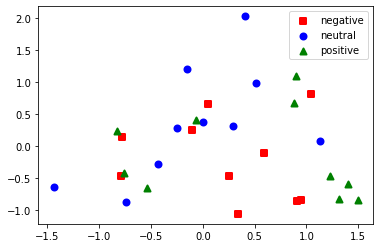

In [ ]:
import matplotlib.pyplot as plt

num_data = 10

plt.scatter(negative_fited[:num_data,0], negative_fited[:num_data,1], c ="red",
            label="negative",
            linewidths = 2,
            marker ="s")

plt.scatter(neutral_fited[:num_data,0], neutral_fited[:num_data,1], c ="blue",
            label="neutral",
            linewidths = 2,
            marker ="o")

plt.scatter(positive_fited[:num_data,0], positive_fited[:num_data,1], c ="green",
            label="positive",
            linewidths = 2,
            marker ="^")

plt.legend()
plt.show()